[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana2/Intro_NLP_Sentimix.ipynb)

# Problema

En este notebook trabajaremos con una base de datos de 2000 tweets que están compuestos por mensajes escritos en "Spanglish" (partes en inglés, partes en español). Cada 'Tweet' se encuentra etiquetado con una de tres categorías: Positivo, Negativo, Neutro, para referirse al sentimiento del contenido. Además, las palabras de cada mensaje se encuentras etiquetadas como inglés, español u alguna otro tipo de etiqueta.

( Para mas información: https://ritual-uh.github.io/sentimix2020/)

# Dependencias

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Curso-WorkingAnalyst/semana2/'

# Carga de los datos

In [ ]:
# Pista: Separador, Header y Comentario
data_raw = pd.read_csv(path + 'spanglish_trial.txt', sep='\t', header=None, comment='"', encoding='utf-8-sig')

In [ ]:
data_raw.head(10)

,0,1,2
0,meta,1,positive
1,So,lang1,NaN
2,that,lang1,NaN
3,means,lang1,NaN
4,tomorrow,lang1,NaN
5,cruda,lang2,NaN
6,segura,lang2,NaN
7,lol,lang1,NaN
8,meta,2,neutral
9,Tonight,lang1,NaN


In [ ]:
aux = data_raw[data_raw[0] == 'meta']
aux

,0,1,2
0,meta,1,positive
8,meta,2,neutral
12,meta,3,negative
20,meta,4,neutral
25,meta,5,negative
...,...,...,...
33449,meta,1996,neutral
33461,meta,1997,positive
33477,meta,1998,positive
33503,meta,1999,positive


In [ ]:
data = pd.DataFrame()

for key, value in enumerate(aux.index):
    a_row = pd.DataFrame(0, index=[0], columns=['#_Tweet', 'Sentimiento', 'Texto', 'lang1', 'lang2'])
    if key == 1999:
        batch = data_raw.loc[value:len(data_raw)-1, :]
    else:
        batch = data_raw.iloc[value:aux.index[key+1], :]

    a_row['#_Tweet'] = batch.iloc[0, 1]
    a_row['Sentimiento'] = batch.iloc[0, 2]
    texto = ''
    for i in range(1, len(batch)):
        texto = texto + batch.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['Texto'] = texto

    aux1 = batch[batch[1] == 'lang1']
    texto = ''
    for i in range(0, len(aux1)):
        texto = texto + aux1.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['lang1'] = texto

    aux2 = batch[batch[1] == 'lang2']
    texto = ''
    for i in range(0, len(aux2)):
        texto = texto + aux2.iloc[i, 0] + ' '
    texto = texto.strip()
    a_row['lang2'] = texto

    data = pd.concat([data, a_row])

data.reset_index(inplace=True, drop=True)

CELDA DE EJERCICIO


In [ ]:
data

,#_Tweet,Sentimiento,Texto,lang1,lang2
0,1,positive,So that means tomorrow cruda segura lol,So that means tomorrow lol,cruda segura
1,2,neutral,Tonight peda segura,Tonight,peda segura
2,3,negative,Eres tan mala vieja bruja interesada #jamming,#jamming,Eres tan mala vieja bruja interesada
3,4,neutral,Yo kiero Pretzels lol,lol,Yo kiero
4,5,negative,Fuck that ni ke el me vaya a mantener toda la ...,Fuck that lol,ni ke el me vaya a mantener toda la vida
...,...,...,...,...,...
1995,1996,neutral,@YoursTrulyXena pound on a cold 40 y se te qui...,pound on a cold lol,y se te quita
1996,1997,positive,@stahrlove hahaa Fuhk you to te doy algo pa qu...,hahaa Fuhk you to,te doy algo pa que jales cabrona
1997,1998,positive,@Yaritzaa__ yo pierdo peso y ni si quiera esto...,lmao I 've been getting tone lol I love waking...,yo pierdo peso y ni si quiera estoy de dieta
1998,1999,positive,@EliZaIBQ Please pay attention . Can I get you...,Please pay attention Can I get your attention ...,presta atencion Puedo tener tu atencion


# Funciones auxiliares para procesamiento de texto

In [ ]:
def remover_stopwords(text, lang):
    stop = re.compile(r'\b(' + r'|'.join(stopwords.words(lang)) + r')\b\s*')
    nuevo_texto = stop.sub('', text)
    return nuevo_texto

In [ ]:
def elimina_puntuacion_y_numeros(text):
    nuevo_texto = re.sub('[^a-z]+', ' ', text)
    return nuevo_texto

In [ ]:
# Solo para inglés
def lematizar(text):
    lemma = WordNetLemmatizer()
    text = text.split()
    nuevo_texto = " ".join([lemma.lemmatize(i) for i in text])
    return nuevo_texto

In [ ]:
def stemmer(text, lang):
    st = SnowballStemmer(lang)
    text = text.split()
    nuevo_texto = ' '.join([st.stem(k) for k in text])
    return nuevo_texto

In [ ]:
def preprocesar(text, lang):
    text = text.lower()
    text = remover_stopwords(text, lang)
    text = elimina_puntuacion_y_numeros(text)
    text = stemmer(text, lang)
    return text

**¿Qué acción realizan las funciones?**

Veamos con un ejemplo.

In [ ]:
eg_string = 'Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, ' \
            'lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the ' \
            'last few characters, often leading to incorrect meanings and spelling errors.'

In [ ]:
eg_string = eg_string.lower()
eg_string

'lemmatization is the process of converting a word to its base form. the difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.'

In [ ]:
remover_stopwords(eg_string, 'english')

'lemmatization process converting word base form. difference stemming lemmatization , lemmatization considers context converts word meaningful base form, whereas stemming removes last characters, often leading incorrect meanings spelling errors.'

In [ ]:
elimina_puntuacion_y_numeros(eg_string.lower())

'lemmatization is the process of converting a word to its base form the difference between stemming and lemmatization is lemmatization considers the context and converts the word to its meaningful base form whereas stemming just removes the last few characters often leading to incorrect meanings and spelling errors '

In [ ]:
stemmer(eg_string, 'english')

'lemmat is the process of convert a word to it base form. the differ between stem and lemmat is, lemmat consid the context and convert the word to it meaning base form, wherea stem just remov the last few characters, often lead to incorrect mean and spell errors.'

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lematizar(eg_string)

'lemmatization is the process of converting a word to it base form. the difference between stemming and lemmatization is, lemmatization considers the context and convert the word to it meaningful base form, whereas stemming just remove the last few characters, often leading to incorrect meaning and spelling errors.'

¿Porque lematizar o stemizar?

In [ ]:
lematizar(remover_stopwords('my feet foot', 'english'))

'foot foot'

In [ ]:
stemmer(remover_stopwords('my feet foot', 'english'), 'english')

'feet foot'

Exploremos nuestros datos

In [ ]:
data.Sentimiento.value_counts()

positive    763
neutral     702
negative    535
Name: Sentimiento, dtype: int64

Preoprocecemos nuestros datos

Ejemplo de función lambda

In [ ]:
numeros = pd.DataFrame({'a':[1,2,3,4]})

In [ ]:
numeros['cuadrados'] = numeros['a'].apply(lambda x: x*x)
numeros

,a,cuadrados
0,1,1
1,2,4
2,3,9
3,4,16


In [ ]:
data['lang1_pp'] = data['lang1'].apply(lambda x: preprocesar(x, 'english'))
data['lang2_pp'] = data['lang2'].apply(lambda x: preprocesar(x, 'spanish'))

In [ ]:
data.head()

,#_Tweet,Sentimiento,Texto,lang1,lang2,lang1_pp,lang2_pp
0,1,positive,So that means tomorrow cruda segura lol,So that means tomorrow lol,cruda segura,mean tomorrow lol,crud segur
1,2,neutral,Tonight peda segura,Tonight,peda segura,tonight,ped segur
2,3,negative,Eres tan mala vieja bruja interesada #jamming,#jamming,Eres tan mala vieja bruja interesada,jam,tan mal viej bruj interes
3,4,neutral,Yo kiero Pretzels lol,lol,Yo kiero,lol,kier
4,5,negative,Fuck that ni ke el me vaya a mantener toda la ...,Fuck that lol,ni ke el me vaya a mantener toda la vida,fuck lol,ke vay manten tod vid


**Representación gráfica para darnos una mejor idea**

In [ ]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Mostrar nuestro gráfico
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

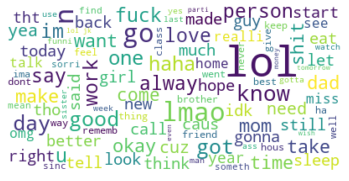

In [ ]:
nube_palabras(data['lang1_pp'])

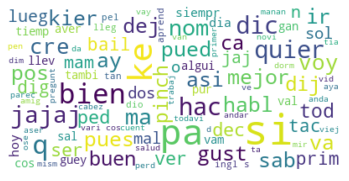

In [ ]:
nube_palabras(data['lang2_pp'])

Si quisieramos ver las nubes de palabras centrandonos mas en el idioma o el sentimiento a analizar

In [ ]:
porClase = data.groupby('Sentimiento')
positivas = porClase.get_group('positive').lang1_pp
negativas = porClase.get_group('negative').lang1_pp
neutras = porClase.get_group('neutral').lang1_pp

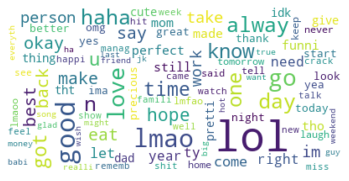

In [ ]:
nube_palabras(positivas)

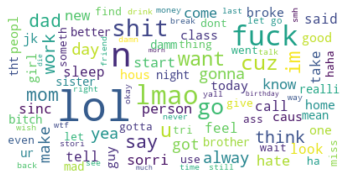

In [ ]:
nube_palabras(negativas)

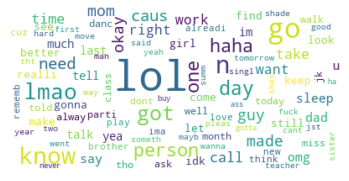

In [ ]:
nube_palabras(neutras)

In [ ]:
positivas_es = porClase.get_group('positive').lang2_pp
negativas_es = porClase.get_group('negative').lang2_pp
neutras_es = porClase.get_group('neutral').lang2_pp

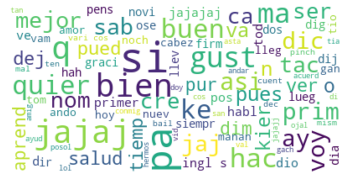

In [ ]:
nube_palabras(positivas_es)

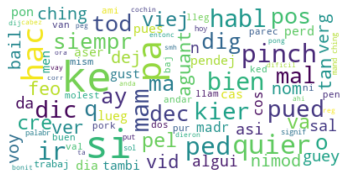

In [ ]:
nube_palabras(negativas_es)

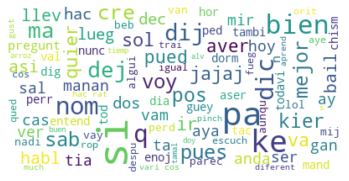

In [ ]:
nube_palabras(neutras_es)

Bolsa de Palabras: Nuestro modo de asignar un vector numérico a nuestras cadenas de caractéres

In [ ]:
# BOW: Bag Of Words
vectorizer = TfidfVectorizer(min_df=2)
BOW_en = vectorizer.fit_transform(data['lang1_pp'])
BOW_en.shape

(2000, 894)

In [ ]:
palabras = vectorizer.get_feature_names_out()
X_en = pd.DataFrame(BOW_en.todense(), index=data.index, columns=palabras)
X_en

,abl,absolut,abt,accept,accid,act,actual,add,af,age,...,yeah,year,yes,yess,yesss,yet,yo,your,yuck,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vectorizer2 = TfidfVectorizer(min_df=2)
BOW_es = vectorizer2.fit_transform(data['lang2_pp'])
BOW_es.shape

(2000, 760)

In [ ]:
palabras_es = vectorizer2.get_feature_names_out()
X_es = pd.DataFrame(BOW_es.todense(), index=data.index, columns=palabras_es)
X_es

,abland,ablar,ablas,abuel,aburr,acab,acav,acent,acept,acord,...,vist,viv,volv,voy,vuelt,wee,wey,xqu,yea,zapat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Así sería la data de entrenamiento de nuestro modelo
X = pd.concat([X_en, X_es], axis=1)

y = data['Sentimiento']

In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train

,abl,absolut,abt,accept,accid,act,actual,add,af,age,...,vist,viv,volv,voy,vuelt,wee,wey,xqu,yea,zapat
968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.348322,0.0,0.0,0.0,0.0,0.0,0.0
